In [1]:
from transforms import *
from utils import *
from model import *
from plots import *
from pathlib import Path
import time

import xgboost as xgb
from sklearn.model_selection import train_test_split

import mlflow
import optuna

c:\Users\Zade\Desktop\PythonStuff\adDetection\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mlflow setup

In [2]:
mlflow.set_tracking_uri("http://localhost:8080")

In [3]:
X_us, y_us, test = init_datasets()

In [4]:
X_us = add_hour_day_from_clicktime(X_us)

In [5]:
grouping_categories = [
    # IP with every other base
    ['ip', 'channel'],
    ['ip', 'device'], 
    ['ip', 'os'],
    ['ip', 'app'],
    # IP and time features - must be done after adding time features
    ['ip', 'day', 'hour'],
    # Perhaps IP isn't as important
    ['app', 'channel'],
    # Triplet(s)
    ['ip', 'app', 'os'],
    # Quartet(s)
    ['ip', 'device', 'os', 'app']
    # Exclude all 5 together as these will be used for grouping
]
grouping_functions = ['nunique', 'cumcount']

In [6]:
X_us = add_groupby_user_features(X_us, grouping_categories=grouping_categories,
                                grouping_functions=grouping_functions)

In [7]:
X_us = add_next_click(X_us)

In [8]:
cols_to_bin = ['next_click'] # Just bin the one for now

In [9]:
X_us = log_bin_column(X_us, cols_to_bin)

c:\Users\Zade\Desktop\PythonStuff\adDetection\addetectionscripts\transforms.py:84: RuntimeWarning: divide by zero encountered in log2
  df[col] = np.log2(1 + df[col].values).astype(int)
c:\Users\Zade\Desktop\PythonStuff\adDetection\addetectionscripts\transforms.py:84: RuntimeWarning: invalid value encountered in log2
  df[col] = np.log2(1 + df[col].values).astype(int)
c:\Users\Zade\Desktop\PythonStuff\adDetection\addetectionscripts\transforms.py:84: RuntimeWarning: invalid value encountered in cast
  df[col] = np.log2(1 + df[col].values).astype(int)


In [10]:
# Drop the original click_time feature
X_us.drop(columns=['click_time'], inplace=True)

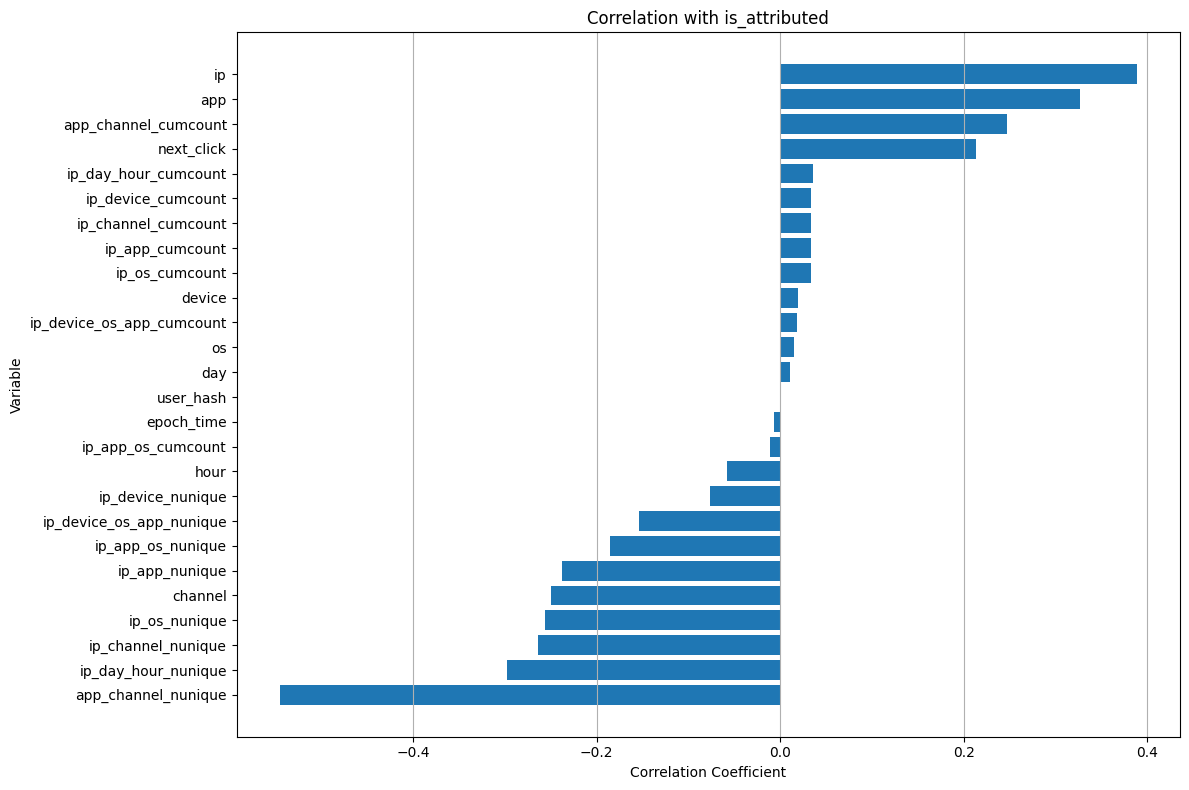

In [11]:
# correlation plot for mlflow
plot_correlation(X_us, y_us, target_col='is_attributed', save_path='test_corr_plot.png')

In [14]:
experiment_id = get_or_create_experiment("Attributed Class.")

In [ ]:
experiment_id

'692440127982257764'

Do an XGBoost model first

In [ ]:
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='file:///c:/Users/Zade/Desktop/PythonStuff/adDetection/addetectionscripts/mlruns/692440127982257764', creation_time=1715550574903, experiment_id='692440127982257764', last_update_time=1715550574903, lifecycle_stage='active', name='Attributed Classification', tags={}>

In [ ]:
test_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_us, y_us, test_size=test_size, random_state=1233)

In [ ]:
# Set to Dmatrix format for training speed
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
# Set optuna to log only errors
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [ ]:
# Run name for mlflow logging
run_name = "first_attempt"

In [ ]:
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Init Optuna
    study = optuna.create_study(direction='maximize') # Want to max our AUC
    
    # Optimize hparams
    study.optimize(objective, n_trials=500, callbacks=[trial_callback])
    
    # Log best params/score
    mlflow.log_params(study.best_params)
    mlflow.log_metric('best_auc', study.best_value)
    
    # Set log tags
    mlflow.set_tags(
        tags={
            'project': 'Ad Fraud Detection',
            'optimizer_engine': 'Optuna',
            'model_family': 'xgboost', 
            'feature_set_version': 1
        }
    )
    
    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)
    
    # Log the correlation plot
    mlflow.log_figure(figure=plot_correlation, artifact_file='correlation_plot.png')
    
    # Log feature importance plot
    importances = plot_feature_importance(model, booster=study.best_params.get('booster'))
    mlflow.log_figure(figure=importances, artifact_file='feature_importances.png')
    
    artifact_path = 'model'
    
    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=X_train.iloc[[0]],
        model_format='ubj',
        metadata={'model_data_version':1}
    )
    
    # Get logged model uri for loading from artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

NameError: name 'trial_callback' is not defined